# COMP9517 Project: Car Detector Pipeline

## Description
The objective of this program is to develop an image processing pipeline to detect cars in an image taken from the front camera.

The techniques applied in this program include HOG feature extraction, logistic regression, sliding windows, heatmap, labelling, etc.

In [1]:
import util
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import json
import glob

In [289]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
# Run this cell first only if you are using Colab
# mount Google Drive to Colab. Ignore if you don't use Colab.
from google.colab import drive
drive.mount('/content/drive')

# specify the project folder
# util.project_folder = 'drive/MyDrive/UNSW/COMP9517/Project/9517Project/'

In [2]:
n_imgs = 1074
img_size = (720, 1280)

## Exploration
To apply sliding window technique, a proper size of window needs to be chosen.

From all cropped images of cars, a set of histograms could be drawn to grasp the general information, such as the width/height ratio, image size. The window size is set to (64 * 48).

It is also noticeable that the cars only appear in a certain part of an image. Thus, setting a proper searching area of sliding window can save tons of computation time without harming the accurarcy. By analysing the distribution of cars' location, we can set the searching area properly.

(array([  0.,   0.,   0.,   4.,  22.,  40., 286., 532., 460.,  66.,  16.,
          8.,   6.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4]),
 <BarContainer object of 14 artists>)

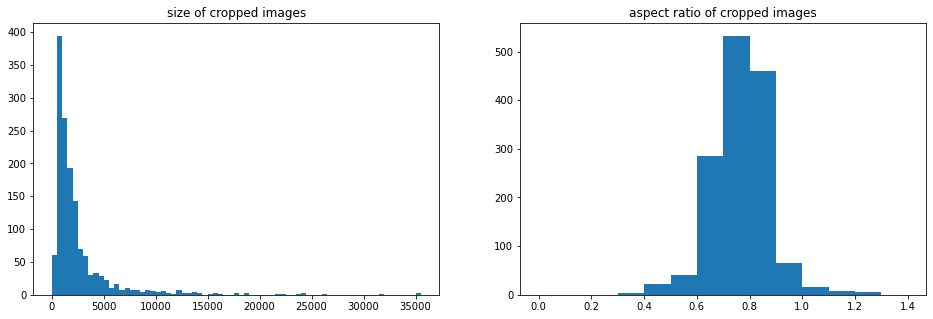

In [5]:
# examine the sizes and height/width ratios of all cropped car images
sizes = []
ratios = []
    
for i in range(1, n_imgs + 1):
    imgs = util.crop_cars('train', i)
    for img in imgs:
        sizes.append(img.shape[0] * img.shape[1])
        ratios.append(img.shape[0] / img.shape[1])

fig, axs = plt.subplots(1, 2, figsize=(16,4))

axs[0].set_title('size of cropped images')
axs[0].hist(sizes, bins=np.arange(0, 36000, 500))

axs[1].set_title('aspect ratio of cropped images')
axs[1].hist(ratios, bins=np.arange(0, 1.5, 0.1))

(array([  3.,  38., 411., 585., 231.,  97.,  34.,  14.,   8.,  21.]),
 array([ 417.89215088,  502.99740601,  588.10266113,  673.20791626,
         758.31317139,  843.41842651,  928.52368164, 1013.62893677,
        1098.73419189, 1183.83944702, 1268.94470215]),
 <BarContainer object of 10 artists>)

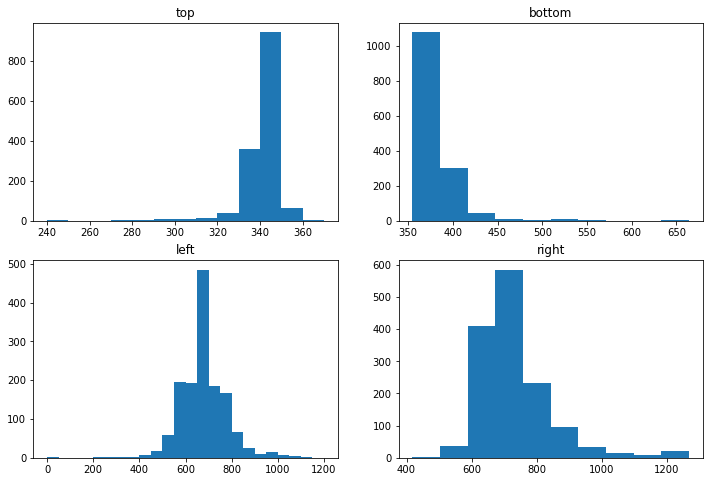

In [8]:
# distribution of positions of bounding boxes
tops = []
bottoms = []
lefts = []
rights = []

for i in range(1, n_imgs + 1):
    with open(f'dataset/velocity/train/clips/{i}/annotation.json') as file:
        annotation = json.load(file)
    for j in range(len(annotation)):
        bboxs = annotation[j]['bbox']
        tops.append(bboxs['top'])
        bottoms.append(bboxs['bottom'])
        lefts.append(bboxs['left'])
        rights.append(bboxs['right'])
        
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0][0].set_title('top')
axs[0][0].hist(tops, bins=np.arange(240, 380, 10))

axs[0][1].set_title('bottom')
axs[0][1].hist(bottoms)

axs[1][0].set_title('left')
axs[1][0].hist(lefts, bins=np.arange(0, 1250, 50))

axs[1][1].set_title('right')
axs[1][1].hist(rights)

In [2]:
# set window size
window_size = (48, 64)

# set the vertical and horizontal search area
min_top, max_top = 260, 640
min_left, max_left = 200, 1150

## Sample training and test images


In [2]:
new_size = (64, 48)

# sample car images and resize
def sample_cars(folder):
    if folder not in ['train', 'test']:
        return
    
    n_imgs = len(glob.glob(f"dataset/velocity/{folder}/clips/*"))
    for i in range(1, n_imgs + 1):
        imgs = util.crop_cars(folder, i)
        for j in range(len(imgs)):
            cv2.imwrite(f'dataset/samples/{folder}/cars/{i}_{j}.jpg', cv2.resize(cv2.cvtColor(imgs[j], cv2.COLOR_BGR2RGB), new_size))

            
# sample non-car images randomly
def sample_noncars(folder, n_samples=1):
    if folder not in ['train', 'test']:
        return
    
    n_imgs = len(glob.glob(f"dataset/velocity/{folder}/clips/*"))
    for i in range(1, n_imgs + 1):
        with open(f'dataset/velocity/{folder}/clips/{i}/annotation.json') as file:
            annotation = json.load(file)
        bboxs = []
        for a in annotation:
            bbox = a['bbox']
            bboxs.append({'top':int(bbox['top']), 'bottom':bbox['bottom'], 'left':int(bbox['left']), 'right':int(bbox['right'])})

        for j in range(n_samples):
            valid = False
            while not valid:
                a, b = random.randint(min_top, max_top - new_size[1]), random.randint(min_left, max_left - new_size[0])
                img = cv2.imread(f'dataset/velocity/{folder}/clips/{i}/imgs/040.jpg')
                cv2.imwrite(f'dataset/samples/{folder}/non-cars/{i}_{j}.jpg', img[a:a+new_size[1], b:b+new_size[0]])
                valid = True
                for bbox in bboxs:
                    if bbox['top'] - new_size[1] <= a <= bbox['bottom'] and bbox['left'] - new_size[0] <= b <= bbox['right']:
                        valid = False
                        break

In [3]:
# sample car and noncar images for both train and test
# run it once for the program

#sample_cars('train')
#sample_cars('test')
#sample_noncars('train', n_samples=10)
#sample_noncars('test')

## HOG feature descriptors

In [3]:
from skimage.feature import hog

pixels_per_cell = 8
cells_per_block = 3

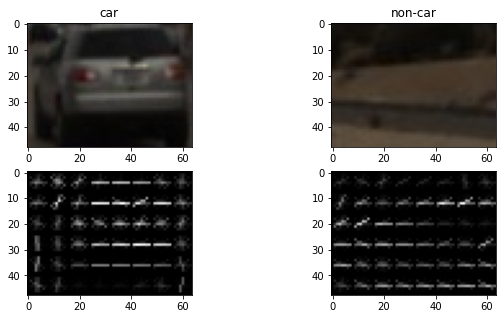

In [11]:
# HOG feature desciptors for cars
car = cv2.imread('dataset/samples/train/cars/1_0.jpg')
fd1, hog_car = hog(car, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(cells_per_block, cells_per_block), visualize=True, multichannel=True)

# HOG feature desciptors for non-cars
noncar = cv2.imread('dataset/samples/test/non-cars/1_0.jpg')
fd2, hog_noncar = hog(noncar, orientations=9, pixels_per_cell=(8, 8),
                     cells_per_block=(cells_per_block, cells_per_block), visualize=True, multichannel=True)

fig, axs = plt.subplots(2, 2, figsize=(10,5))
axs[0][0].set_title('car')
axs[0][0].imshow(cv2.cvtColor(car, cv2.COLOR_BGR2RGB), cmap='gray')
axs[1][0].imshow(hog_car, cmap='gray')
axs[0][1].set_title('non-car')
axs[0][1].imshow(cv2.cvtColor(noncar, cv2.COLOR_BGR2RGB), cmap='gray')
axs[1][1].imshow(hog_noncar, cmap='gray')

In [12]:
fd1.shape

(1944,)

## Load training and test data

In [4]:
# load training set images
def load_dataset(mode='train'):
    if mode not in ['train', 'test']:
        return
    
    car_imgs = []
    noncar_imgs = []
    
    for img_path in glob.glob(f"dataset/samples/{mode}/cars/*.jpg"):
        car_imgs.append(cv2.imread(img_path))
    for img_path in glob.glob(f"dataset/samples/{mode}/non-cars/*.jpg"):
        noncar_imgs.append(cv2.imread(img_path))

    n_train = len(car_imgs) + len(noncar_imgs)

    # create dataset
    X = []
    for car_img in car_imgs:
        X.append(hog(car_img, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), visualize=False, multichannel=True))
    for noncar_img in noncar_imgs:
        X.append(hog(noncar_img, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), visualize=False, multichannel=True))

    X = np.array(X)
    y = np.append(np.ones((len(car_imgs))), np.zeros((len(noncar_imgs))))
    return X, y

In [5]:
X_train, y_train = load_dataset('train')
X_test, y_test = load_dataset('test')

In [6]:
X_train.shape

(12106, 1944)

In [7]:
y_train.shape

(12106,)

## Train the classifier

In [73]:
from sklearn.svm import LinearSVC
# train the model
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

In [74]:
svc.score(X_test, y_test)

0.9860248447204969

In [15]:
#svc.predict(X_test)

In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [9]:
lr.score(X_test, y_test)

0.984472049689441

In [42]:
#lr.predict_proba(X_test)

## Sliding Window

In [10]:
# version1: Slice HOG of the entire image. Way Faster.
def sliding_window(img, scale=1, step_size=1, visualize=False):
    # resize
    img = cv2.resize(img, (int(img_test.shape[1] / scale), int(img_test.shape[0] / scale)))
    window_size = (48, 64)
    n_blocks = (int(720 / scale / 8 - 3 + 1), int(1280 / scale / 8 - 3 + 1)) # (88, 158)
    n_blocks_in_window = (window_size[0] // 8 - 3 + 1, window_size[1] // 8 - 3 + 1) # (4, 6)
    
    hog_fd = hog(img, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), visualize=False, multichannel=True, feature_vector=False)
    windows = []
    min_top, max_top = 280, 380
    min_left, max_left = 200, 1150
    
    for i in range((n_blocks[0] - n_blocks_in_window[0]) // step_size):
        for j in range((n_blocks[1] - n_blocks_in_window[1]) // step_size):
            if i * step_size * 8 > max_top / scale or i * step_size * 8 < min_top / scale \
            or j * step_size * 8 > max_left / scale or j * step_size * 8 < min_left / scale:
                continue

            hog_fd_window = hog_fd[i*step_size:i*step_size+n_blocks_in_window[0], j*step_size:j*step_size+n_blocks_in_window[1]].ravel()

            if lr.predict_proba(hog_fd_window.reshape((1, -1)))[0][1] > 0.75:
                windows.append([i, j, scale])
    
    if visualize:
        img_cpy = img.copy()
        for w in windows:
            a = w[0] * step_size * 8
            b = w[1] * step_size * 8
            cv2.rectangle(img_cpy, (b, a), (b+64, a+48), color=(0, 255, 0), thickness=2)
        plt.imshow(img_cpy)
    
    return windows


# version2: naively compute HOG for each sliding window
def sliding_window2(img, scale=1, step_size=8, visualize=False):
    # resize
    img = cv2.resize(img, (int(img_test.shape[1] / scale), int(img_test.shape[0] / scale)))
    window_size = (48, 64)
    windows = []
    
    min_top, max_top = 260, 640
    min_left, max_left = 200, 1150
    
    for i in range(int(min_top / scale / step_size), int((max_top / scale - 48) / step_size)):
        for j in range(int(min_left / scale / step_size), int((max_left / scale - 64) / step_size)):
    
            top_start, left_start = i * step_size, j * step_size
            window = img[top_start:top_start + 48, left_start:left_start + 64]
            hog_window = hog(window, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), 
                             visualize=False, multichannel=True, feature_vector=True)
            if svc.predict(hog_window.reshape((1, -1))):
                windows.append([i, j, scale])
    
    if visualize:
        img_cpy = img.copy()
        for w in windows:
            a = w[0] * step_size
            b = w[1] * step_size
            cv2.rectangle(img_cpy, (b, a), (b+64, a+48), color=(0, 255, 0), thickness=2)
        plt.imshow(img_cpy)
    
    return windows


def pyramid(img, scales, step_size, visualize=False):
    windows = []
    for s in scales:
        windows += sliding_window(img, scale=s, step_size=step_size, visualize=False)
    # visualize bounding boxs
    if visualize:
        img_cpy = img.copy()
        for w in windows:
            a = w[0] * step_size * 8
            b = w[1] * step_size * 8
            scale = w[2]
            cv2.rectangle(img_cpy, (int(b*scale), int(a*scale)), (int((b+64)*scale), int((a+48)*scale)), color=(0, 255, 0), thickness=2)
        plt.imshow(img_cpy)
    return windows

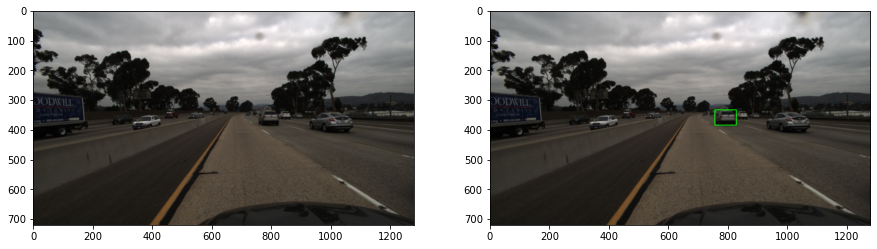

In [22]:
# Ground Truth
img_id = 2
img_test = util.read_velocity_image('test', img_id, False)
fig, axs = plt.subplots(1, 2, figsize=(15,7))
axs[0].imshow(img_test)
axs[1].imshow(util.read_velocity_image('test', img_id, True))

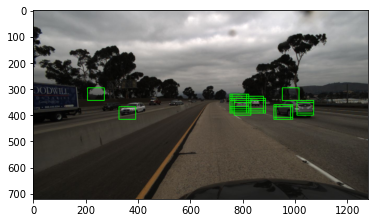

In [23]:
step_size=1
res = sliding_window(img_test, scale=1,step_size=step_size, visualize=True)

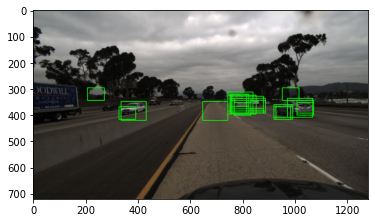

In [24]:
res = pyramid(img_test, scales=[1, 1.5, 2], step_size=step_size, visualize=True)

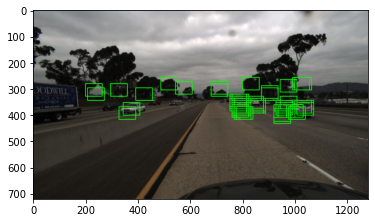

In [75]:
step_size=8
res = sliding_window2(img_test, scale=1, step_size=step_size, visualize=True)

## Heatmap

In [11]:
# generate the heatmap
def get_heatmap(rectangles, step_size, threshold=0):
    heatmap = np.zeros((720, 1280))
    for r in rectangles:
        a = r[0] * step_size
        b = r[1] * step_size
        scale = r[2]
        for i in range(int(a * scale), int((a + 48) * scale)):
            for j in range(int(b * scale), int((b + 64) * scale)):
                heatmap[i][j] += 1
    #plt.imshow(heatmap)
    uniques = np.unique(heatmap)
    #print(uniques)

    #threshold = 0
    if len(uniques) == 2:
        threshold = 0
    else:
        threshold = threshold

    # apply threshold to remove false positives
    heatmap -= threshold
    heatmap[heatmap < 0] = 0
    
    return heatmap

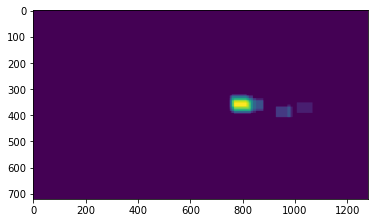

In [27]:
heatmap = get_heatmap(res, step_size=8, threshold=2)
plt.imshow(heatmap)

## Labelling

In [12]:
from scipy.ndimage.measurements import label

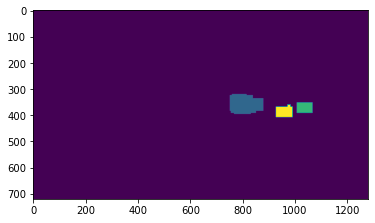

In [28]:
labels = label(heatmap)
plt.imshow(labels[0])

## Combine bounding boxes

In [13]:
def combine_bounding_boxes(img, labels, min_area=0, max_area=float('inf'), min_ratio=0.2, max_ratio=2, visualize=False):
    # get the max boundries of the labeled areas
    bboxes = []
    for label in range(1, labels[1] + 1):
        nonzeros = np.nonzero(labels[0] == label)
        bbox = ((min(nonzeros[0]), min(nonzeros[1])), (max(nonzeros[0]), max(nonzeros[1])))
        area = (bbox[1][0] - bbox[0][0]) * (bbox[1][1] - bbox[0][1])
        ratio = (bbox[1][0] - bbox[0][0]) / (bbox[1][1] - bbox[0][1])
        #print(ratio)
        if min_area < area < max_area and min_ratio < ratio < max_ratio:
            bboxes.append(bbox)
    
    # visualize
    if visualize:
        img_cpy = img.copy()
        for bbox in bboxes:
            cv2.rectangle(img_cpy, (bbox[0][1], bbox[0][0]), (bbox[1][1], bbox[1][0]), color=(0, 255, 0), thickness=2)
        plt.imshow(img_cpy)
    
    return bboxes

0.8873239436619719


[((336, 680), (399, 751))]

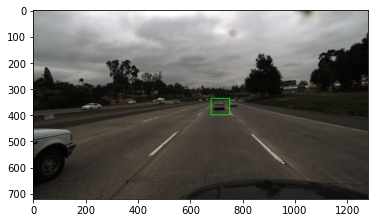

In [528]:
combine_bounding_boxes(img_test, labels, visualize=True)

## pipeline

In [19]:
def detect_cars(img, save_img=False):
    rectangles = pyramid(img, scales=[1, 1.5, 2], step_size=1)
    heatmap = get_heatmap(rectangles, step_size=8, threshold=2)
    #plt.imshow(heatmap)
    labels = label(heatmap)
    bboxes = combine_bounding_boxes(img, labels, min_area=100)
    
    # save output images
    if save_img:
        out = img.copy()
        for bbox in bboxes:
            cv2.rectangle(out, (bbox[0][1], bbox[0][0]), (bbox[1][1], bbox[1][0]), color=(0, 255, 0), thickness=2)
        return bboxes, out
    
    return bboxes

## Generate the test results

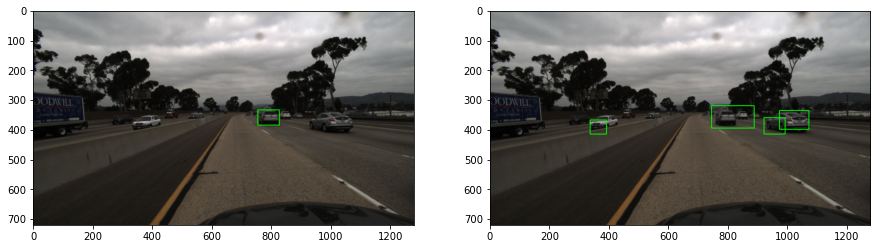

In [64]:
i = 2
img_test = util.read_velocity_image('test', i, annotation=False)
bboxes, output = detect_cars(img_test, save_img=True)
# visualize results
fig, axs = plt.subplots(1, 2, figsize=(15,7))
axs[0].imshow(util.read_velocity_image('test', i, annotation=True))
axs[1].imshow(output)

In [20]:
n_test = 269
pred = []

for i in range(1, n_test + 1):
    img_test = util.read_velocity_image('test', i, annotation=False)
    bboxes = detect_cars(img_test, save_img=False)
    bbox_list = []
    for bbox in bboxes:
        bbox_list.append({"bbox":{"top":float(bbox[0][0]), "right":float(bbox[1][1]), "left":float(bbox[0][1]), "bottom":float(bbox[1][0])}})
    pred.append(bbox_list)
    #gt = util.read_velocity_image('test', i, annotation=True)
    #combine = np.concatenate((gt, output), axis=1)
    #cv2.imwrite(f'dataset/output/car_detection/3/{i}.jpg', cv2.cvtColor(combine, cv2.COLOR_BGR2RGB))
    print(i)

with open('dataset/output/car_detection/pred2.json', 'w', encoding='utf-8') as f:
    json.dump(pred, f, ensure_ascii=False, indent=4)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269


## Evaluation

In [16]:
# calculate the intersection over union of 2 bboxes
def IOU(bbox1, bbox2):
    x1, y1 = max(bbox1[0], bbox2[0]), max(bbox1[1], bbox2[1])
    x2, y2 = min(bbox1[2], bbox2[2]), min(bbox1[3], bbox2[3])
    
    # area of intersection
    area_intersect = max(0, x2 - x1) * max(0, y2 - y1)

    # areas of 2 bounding boxes
    area1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    area2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

    iou = float(area_intersect) / float(area1 + area2 - area_intersect)

    return iou

In [38]:
# calculate the accuracy score based on mean IoU
def IOU_metrics(gt, pred):
    pred_bbox_list = []
    res = []
    for info in pred:
        bbox_list = []
        for item in info:
            bbox = item['bbox']
            b = (bbox['top'], bbox['left'], bbox['bottom'], bbox['right'])
            bbox_list.append(b)
        pred_bbox_list.append(bbox_list)

    for i in range(len(gt)):
        sum_iou = 0
        for j in range(len(gt[i])):
            bbox = gt[i][j]['bbox']
            b = (bbox['top'], bbox['left'], bbox['bottom'], bbox['right'])
            max_iou = 0
            for pred_b in pred_bbox_list[i]:
                max_iou = max(max_iou, IOU(b, pred_b))
            sum_iou += max_iou
        res.append(sum_iou / len(gt[i]))
        
    print(f'The mean IoU of the {len(pred)} test examples is: {sum(res) / len(res)}')

In [42]:
path_gt = 'dataset/velocity/gt.json'
path_pred = 'dataset/output/car_detection/pred2.json'

with open(path_gt) as file:
    gt = json.load(file)

with open(path_pred) as file:
    pred = json.load(file)
    
IOU_metrics(gt, pred)

The mean IoU of the 269 test examples is: 0.2285964933181621
